## Classification DMS

In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
# %matplotlib inline
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K
from keras_bert import load_vocabulary
from keras.layers import concatenate, Dropout, Add
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import _pickle as pickle

Using TensorFlow backend.


In [2]:
%env epochs 1000
%env method baseline
%env base openoffice

env: epochs=1000
env: method=baseline
env: base=openoffice


## Configurações Globais

In [3]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = int(os.environ['epochs'])

In [4]:
DOMAIN = os.environ['base']
METHOD = '{}_{}'.format(os.environ['method'], epochs)
PREPROCESSING = 'bert'
TOKEN = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, \
                                                                                             METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [5]:
print("*********")
print("{} for {} epochs in {}".format(METHOD, epochs, DOMAIN))
print("*********")

*********
baseline_1000 for 1000 epochs in openoffice
*********


In [6]:
print(PRETRAINED_MODEL)

modelos/model_bert_preprocessing_baseline_1000_feature_1000epochs_64batch(openoffice).h5


In [7]:
K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]
MAX_SEQUENCE_LENGTH_I = K.int_shape(similarity_model.input[2])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, MAX_SEQUENCE_LENGTH_I

(100, 100, 738)

In [9]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_severity': 6,
 'bug_status': 3,
 'component': 144,
 'priority': 5,
 'product': 41,
 'version': 539}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [14]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


98070

#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 22.1 s, sys: 1.32 s, total: 23.4 s
Wall time: 23 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 450 ms, sys: 731 µs, total: 451 ms
Wall time: 446 ms


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)
print(len(bug_train_ids))

104492
CPU times: user 10.1 ms, sys: 320 µs, total: 10.4 ms
Wall time: 10.3 ms


In [18]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(issues_by_buckets, DIR, baseline.bug_set, 
                                                                                      bug_train_ids, 
                                                                                      path="test_chronological")

Reading test data for classification
CPU times: user 7.75 ms, sys: 589 µs, total: 8.33 ms
Wall time: 7.73 ms


In [19]:
print(len(baseline.test_data))

4116


## Siamese  model

In [20]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [21]:
bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')

bug_i_a = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_a')
bug_i_b = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_b')

title_encoder = similarity_model.get_layer('FeatureLstmGenerationModel')
desc_encoder = similarity_model.get_layer('FeatureCNNGenerationModel')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder(bug_t_a)
bugt_d_a = desc_encoder(bug_d_a)
bugt_i_a = info_encoder(bug_i_a)
# Bug B
bugt_t_b = title_encoder(bug_t_b)
bugt_d_b = desc_encoder(bug_d_b)
bugt_i_b = info_encoder(bug_i_b)

bug_a = model([bugt_i_a, bugt_t_a, bugt_d_a])
bug_b = model([bugt_i_b, bugt_t_b, bugt_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
#     x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a, bug_t_b, bug_d_a, bug_d_b, bug_i_a, bug_i_b], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_a (InputLayer)             (None, 738)          0                                            
__________________________________________________________________________________________________
title_a (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 100)          0                                            
________________________________________________________________________________________________

In [22]:
def batch_classification(train, dup_sets, batch_size, n_neg, bug_ids):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(retrieval, None, train, dup_sets, bug_ids, 
                                                                                     batch_size_normalized, n_neg,
                                                                                    issues_by_buckets
                                                                                    )
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg, bug_ids):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, 
                                                                                     n_neg, bug_ids)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [23]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [24]:
bug_test_ids = experiment.get_train_ids(baseline.test_data)

In [25]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test,
                                                                             512, 1, bug_test_ids)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [26]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 64, 
                                                             1, bug_train_ids), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/100
10/10 [==============================] - 2s 213ms/step - loss: 0.7366 - acc: 0.4844 - val_loss: 0.7187 - val_acc: 0.4609
Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 0.7070 - acc: 0.5250 - val_loss: 0.7046 - val_acc: 0.4883
Epoch 3/100
10/10 [==============================] - 1s 113ms/step - loss: 0.7119 - acc: 0.5094 - val_loss: 0.6940 - val_acc: 0.5566
Epoch 4/100
10/10 [==============================] - 1s 111ms/step - loss: 0.6943 - acc: 0.5594 - val_loss: 0.6919 - val_acc: 0.5254
Epoch 5/100
10/10 [==============================] - 1s 112ms/step - loss: 0.7037 - acc: 0.5187 - val_loss: 0.6835 - val_acc: 0.5273
Epoch 6/100
10/10 [==============================] - 1s 115ms/step - loss: 0.6727 - acc: 0.5828 - val_loss: 0.6827 - val_acc: 0.5332
Epoch 7/100
10/10 [==============================] - 1s 101ms/step - loss: 0.6687 - acc: 0.5953 - val_loss: 0.6684 - val_acc: 0.5977
Epoch 8/100
10/10 [==============================] - 1s 115ms/step 

10/10 [==============================] - 1s 98ms/step - loss: 0.3980 - acc: 0.8125 - val_loss: 0.5971 - val_acc: 0.7148
Epoch 60/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4233 - acc: 0.7984 - val_loss: 0.6182 - val_acc: 0.7188
Epoch 61/100
10/10 [==============================] - 1s 114ms/step - loss: 0.3467 - acc: 0.8641 - val_loss: 0.5749 - val_acc: 0.7285
Epoch 62/100
10/10 [==============================] - 1s 99ms/step - loss: 0.4340 - acc: 0.8109 - val_loss: 0.5827 - val_acc: 0.7324
Epoch 63/100
10/10 [==============================] - 1s 103ms/step - loss: 0.3981 - acc: 0.8187 - val_loss: 0.5689 - val_acc: 0.7227
Epoch 64/100
10/10 [==============================] - 1s 112ms/step - loss: 0.3393 - acc: 0.8406 - val_loss: 0.5521 - val_acc: 0.7324
Epoch 65/100
10/10 [==============================] - 1s 112ms/step - loss: 0.3557 - acc: 0.8469 - val_loss: 0.5596 - val_acc: 0.7480
Epoch 66/100
10/10 [==============================] - 1s 112ms/step - loss: 0

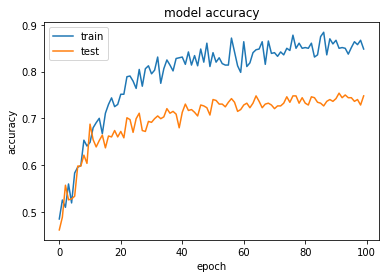

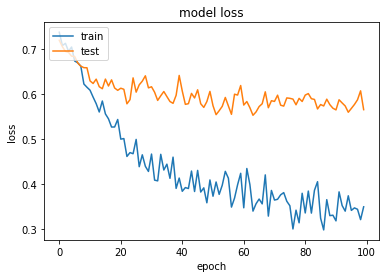

In [27]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [28]:
result = { }

In [29]:
number_of_pairs = len(baseline.test_data)

#### train

In [30]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 
                                                                             number_of_pairs, 1, bug_train_ids)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_train_scores = [ decode_ohe(r) for r in y_scores ]
y_train_true = [ decode_ohe(r) for r in y_true ]

#### test

In [31]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=False)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_test_scores = [ decode_ohe(r) for r in y_scores ]
y_test_true = [ decode_ohe(r) for r in y_true ]

In [32]:
acc_train = accuracy_score(y_train_true, y_train_scores)
print("acc_train", acc_train)

acc_train 0.8892128279883382


In [33]:
acc_test = accuracy_score(y_test_true, y_test_scores)
print("acc_test", acc_test)

acc_test 0.7490281827016521


### Roc AUC/SCORE

#### train

In [34]:
roc_train = roc_auc_score(y_train_true, y_train_scores)
print("roc_train", roc_train)

roc_train 0.8892128279883383


#### test

In [35]:
roc_test = roc_auc_score(y_test_true, y_test_scores)
print("roc_test", roc_test)

roc_test 0.7490281827016521


#### Confusion Matrix

https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

In [39]:
#pred = np.argmax(y_test_scores, axis=1)
pred = y_test_scores #pred.tolist()
pred

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [40]:
# label = np.argmax(y_test_true, axis=1)
label = y_test_true#label.tolist()
label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Normalized confusion matrix
[[0.78620019 0.21379981]
 [0.28814383 0.71185617]]


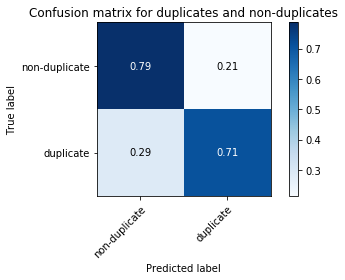

resultados/classification_openoffice_baseline_1000.png


In [41]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD))

Normalized confusion matrix
[[0.78620019 0.21379981]
 [0.28814383 0.71185617]]


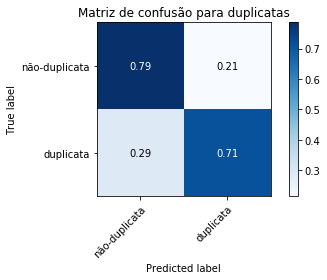

resultados/classification_openoffice_baseline_1000_pt.png


In [42]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicata', 'duplicata']), 
                      title='Matriz de confusão para duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD))

### Save results for each instance tested

In [54]:
print(DIR, SAVE_PATH.replace('({})'.format(DOMAIN), ''))

data/processed/openoffice/bert baseline_1000_classification


In [55]:
def save_result(result):
    name = SAVE_PATH.replace('({})'.format(DOMAIN), '')
    with open(os.path.join(DIR,'{}.pkl'.format(name)), 'wb') as f:
        pickle.dump(result, f)
    print("=> saved result for classification by instance!")

In [58]:
acc = [int(x == y) for x, y in zip(y_test_scores, y_test_true)]

In [59]:
save_result({ 'y_pred' : y_test_scores, 'y_true' : y_test_true, 'acc' : acc })

=> saved result for classification by instance!


#### Save the model

In [43]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [44]:
CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)

print(CLASSIFICATION_PATH)

classification_baseline_1000.pkl


In [45]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [46]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

All saved.


In [47]:
result

{'acc_test': 0.7490281827016521,
 'acc_train': 0.8892128279883382,
 'method': 'baseline_1000',
 'roc_test': 0.7490281827016521,
 'roc_train': 0.8892128279883383}